In [ ]:
import yfinance as yf

tsla = yf.download('META', start='2020-06-06', end='2025-06-06')
tsla.reset_index(inplace=True)
tsla.to_csv("META.csv", index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score



import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

df = pd.read_csv("META.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close', 'Volume','High','Low','Open']]


In [ ]:
df.dropna(subset=['Close'], inplace=True)
df = df.dropna(subset=['Close'])


In [ ]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')


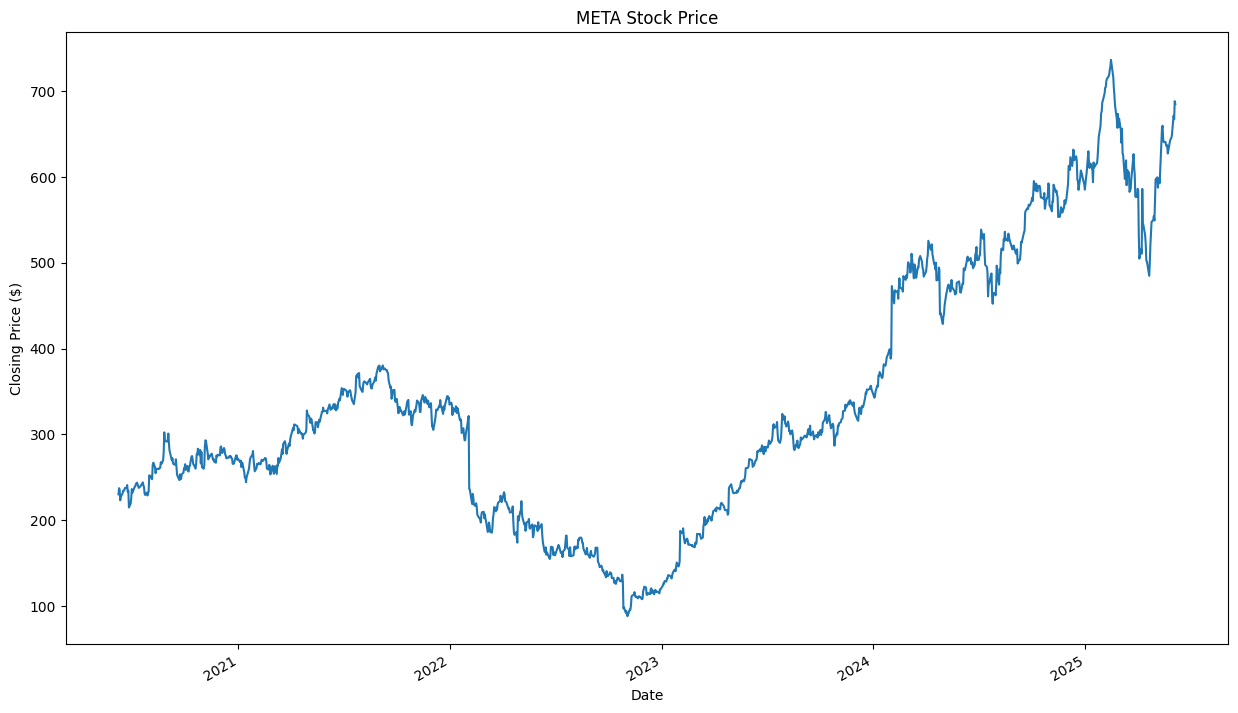

In [ ]:
import matplotlib.pyplot as plt

df.set_index('Date')['Close'].plot(figsize=(15, 9), title='META Stock Price')
plt.xlabel("Date"); plt.ylabel("Closing Price ($)")
plt.show()


In [ ]:
arim=df[['Date','Close']]
arim

,Date,Close
1,2020-06-08,230.314514
2,2020-06-09,237.550415
3,2020-06-10,235.619522
4,2020-06-11,223.377197
5,2020-06-12,227.507751
...,...,...
1252,2025-05-30,647.489990
1253,2025-06-02,670.900024
1254,2025-06-03,666.849976
1255,2025-06-04,687.950012


In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Date      0
Close     0
Volume    0
High      0
Low       0
Open      0
dtype: int64


In [ ]:
display(df.head())

,Date,Close,Volume,High,Low,Open
0,NaT,NaN,META,META,META,META
1,2020-06-08,230.314514,15466500,230.46381963391454,226.34324066589275,227.95563650944567
2,2020-06-09,237.550415,27462900,238.64526109613027,229.32916754933692,230.43396122975577
3,2020-06-10,235.619522,20720700,240.07851785626352,234.17632691815564,239.82969057798536
4,2020-06-11,223.377197,26708200,231.7975183023148,222.50133565063507,228.86135971502455


In [ ]:
display(df.tail())

,Date,Close,Volume,High,Low,Open
1252,2025-05-30,647.489990,16241000,649.4099731445312,632.780029296875,642.5
1253,2025-06-02,670.900024,15766300,673.260009765625,644.260009765625,644.3900146484375
1254,2025-06-03,666.849976,11585000,675.5800170898438,665.030029296875,671.4500122070312
1255,2025-06-04,687.950012,14031900,689.0,668.5700073242188,669.3200073242188
1256,2025-06-05,684.619995,13083100,694.3800048828125,682.25,691.6599731445312


In [ ]:
df = df.dropna(subset=['Date', 'Close'])

In [ ]:
close_meta = df.set_index('Date')[['Close']]
close_meta



,Close
Date,
2020-06-08,230.3145294189453
2020-06-09,237.55043029785156
2020-06-10,235.61952209472656
2020-06-11,223.37721252441406
2020-06-12,227.5077667236328
...,...
2025-05-30,647.489990234375
2025-06-02,670.9000244140625
2025-06-03,666.8499755859375


In [ ]:
forecast_out = 30

# Create column for target variable shifted 'n' days up
close_meta['Prediction'] = close_meta[['Close']].shift(-forecast_out)

close_meta

,Close,Prediction
Date,,
2020-06-08,230.3145294189453,240.615966796875
2020-06-09,237.55043029785156,238.74476623535156
2020-06-10,235.61952209472656,231.50889587402344
2020-06-11,223.37721252441406,229.6277618408203
2020-06-12,227.5077667236328,232.40467834472656
...,...,...
2025-05-30,647.489990234375,None
2025-06-02,670.9000244140625,None
2025-06-03,666.8499755859375,None


In [ ]:
X = np.array(close_meta.drop(['Prediction'],axis= 1))
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[['230.3145294189453']
 ['237.55043029785156']
 ['235.61952209472656']
 ...
 ['484.6600036621094']
 ['500.2799987792969']
 ['520.27001953125']]


In [ ]:
y = np.array(close_meta['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

['240.615966796875' '238.74476623535156' '231.50889587402344' ...
 '666.8499755859375' '687.9500122070312' '684.6199951171875']


In [ ]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(858, 1)
(858,)
(368, 1)
(368,)


In [ ]:
X_forecast = np.array(close_meta.drop(['Prediction'],axis=1))[-forecast_out:]
print(X_forecast)

[['533.1500244140625']
 ['547.27001953125']
 ['549.739990234375']
 ['554.4400024414062']
 ['549.0']
 ['572.2100219726562']
 ['597.02001953125']
 ['599.27001953125']
 ['587.3099975585938']
 ['596.8099975585938']
 ['598.010009765625']
 ['592.489990234375']
 ['639.4299926757812']
 ['656.030029296875']
 ['659.3599853515625']
 ['643.8800048828125']
 ['640.3400268554688']
 ['640.4299926757812']
 ['637.0999755859375']
 ['635.5']
 ['636.5700073242188']
 ['627.0599975585938']
 ['642.3200073242188']
 ['643.5800170898438']
 ['645.0499877929688']
 ['647.489990234375']
 ['670.9000244140625']
 ['666.8499755859375']
 ['687.9500122070312']
 ['684.6199951171875']]


In [ ]:
models = {}
models["Linear"] = LinearRegression()

In [ ]:
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
predictions = lr.predict(X_test)

In [ ]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error

# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [0.9022004]
R^2 score: 0.2


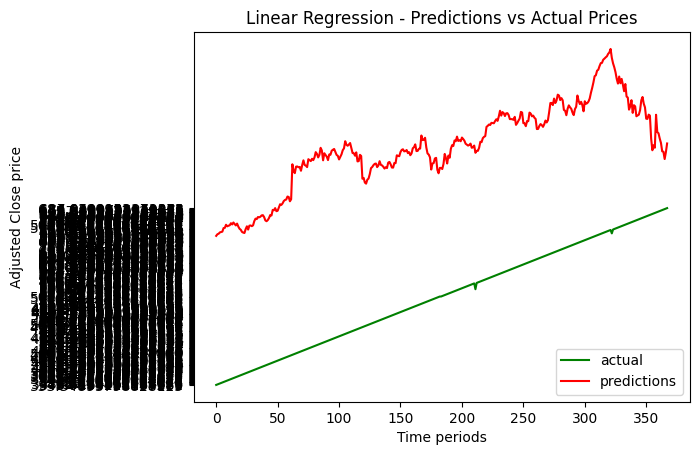

In [ ]:

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [ ]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,333.34893798828125,306.885134
1,343.0034484863281,310.234548
2,348.7165222167969,311.312106
3,347.64154052734375,314.023993
4,352.428955078125,314.886051


TypeError: can only concatenate str (not "float") to str

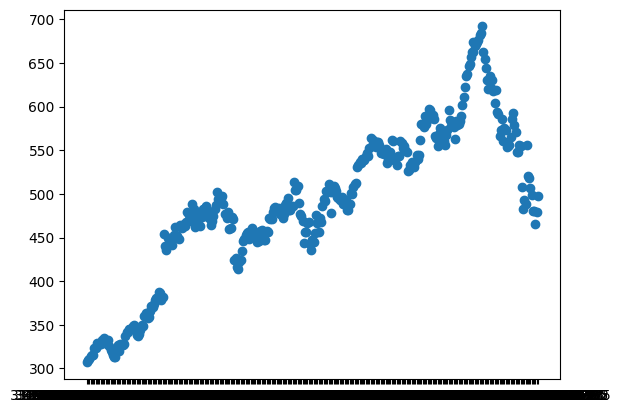

In [ ]:
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: Yi")
plt.ylabel("Predicted prices: Yi")
plt.title("Prices vs Predicted prices:")
plt.show()

In [ ]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[508.74190143 521.48096669 523.70937525 527.94972814 523.04175576
 543.98184688 566.36543662 568.39538752 557.60505091 566.17595472
 567.25860621 562.27844238 604.62773139 619.60429108 622.60857877
 608.64253418 605.44876459 605.52993179 602.52558904 601.08209042
 602.04745146 593.46751684 607.23510376 608.37188508 609.69809324
 611.89946442 633.02000663 629.36605096 648.40251245 645.3981697 ]


In [ ]:
# Actual prices

X_forecast

array([['533.1500244140625'],
       ['547.27001953125'],
       ['549.739990234375'],
       ['554.4400024414062'],
       ['549.0'],
       ['572.2100219726562'],
       ['597.02001953125'],
       ['599.27001953125'],
       ['587.3099975585938'],
       ['596.8099975585938'],
       ['598.010009765625'],
       ['592.489990234375'],
       ['639.4299926757812'],
       ['656.030029296875'],
       ['659.3599853515625'],
       ['643.8800048828125'],
       ['640.3400268554688'],
       ['640.4299926757812'],
       ['637.0999755859375'],
       ['635.5'],
       ['636.5700073242188'],
       ['627.0599975585938'],
       ['642.3200073242188'],
       ['643.5800170898438'],
       ['645.0499877929688'],
       ['647.489990234375'],
       ['670.9000244140625'],
       ['666.8499755859375'],
       ['687.9500122070312'],
       ['684.6199951171875']], dtype=object)

In [ ]:
# The coefficients
print('Coefficients: ', lr.coef_)
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))


Coefficients:  [0.9022004]
R^2 score: 0.399


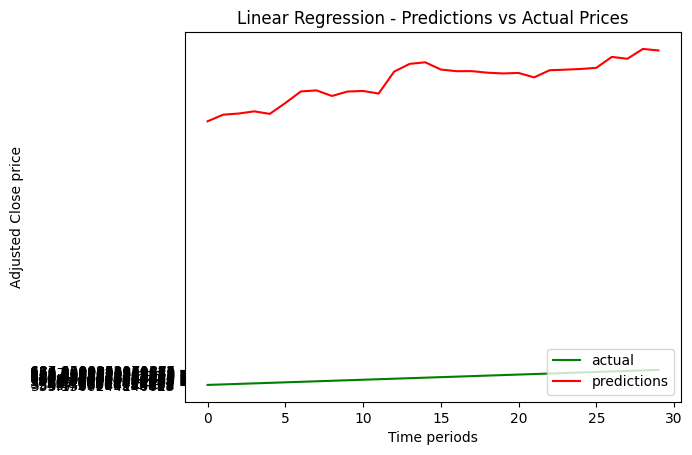

In [ ]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast[:, 0], color='g', label="actual")

plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)
X_forecast

array(['533.1500244140625', '547.27001953125', '549.739990234375',
       '554.4400024414062', '549.0', '572.2100219726562',
       '597.02001953125', '599.27001953125', '587.3099975585938',
       '596.8099975585938', '598.010009765625', '592.489990234375',
       '639.4299926757812', '656.030029296875', '659.3599853515625',
       '643.8800048828125', '640.3400268554688', '640.4299926757812',
       '637.0999755859375', '635.5', '636.5700073242188',
       '627.0599975585938', '642.3200073242188', '643.5800170898438',
       '645.0499877929688', '647.489990234375', '670.9000244140625',
       '666.8499755859375', '687.9500122070312', '684.6199951171875'],
      dtype=object)

In [ ]:
pd.DataFrame({"Actual": X_forecast, "Predict": lr_prediction}).head()

,Actual,Predict
0,533.1500244140625,508.741901
1,547.27001953125,521.480967
2,549.739990234375,523.709375
3,554.4400024414062,527.949728
4,549.0,523.041756


Time series model Arima


In [ ]:
close_meta

,Close,Prediction
Date,,
2020-06-08,230.3145294189453,240.615966796875
2020-06-09,237.55043029785156,238.74476623535156
2020-06-10,235.61952209472656,231.50889587402344
2020-06-11,223.37721252441406,229.6277618408203
2020-06-12,227.5077667236328,232.40467834472656
...,...,...
2025-05-30,647.489990234375,None
2025-06-02,670.9000244140625,None
2025-06-03,666.8499755859375,None


In [ ]:
from google.colab import files

# Save your DataFrame to a CSV file
close_meta.to_csv('stock prediction 30 days.csv', index=True)

# Download it to your local system
files.download('stock prediction 30 days.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cm = close_meta.reset_index()
cm.to_csv('my_data.csv', index=False)

